TODOS:
- figure out the shape - solid understanding
- shape vs size?
- check all the device!
- train properly
- draw image from left to right
- optimize code in positional encoding, ...

In [ ]:
# masking
inp = torch.randn(4,4)
F.softmax(inp.masked_fill(torch.tril(torch.ones(4,4))==0,float("-inf")),dim=-1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5093, 0.4907, 0.0000, 0.0000],
        [0.4135, 0.3646, 0.2219, 0.0000],
        [0.2161, 0.3955, 0.2536, 0.1348]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

import numpy as np
import os

In [ ]:
os.cpu_count()

2

In [ ]:
path = './datasets/'

transform = transforms.Compose([transforms.ToTensor()])

train_data = CIFAR100(root=path,train=True,transform=transform,download=True)
test_data = CIFAR100(root=path,train=False,transform=transform,download=True)

batch_size = 100

train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count())
test_loader = DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count())

input_shape = train_data[0][0].shape
output_shape = len(train_data.classes)
print()

100%|██████████| 169M/169M [00:12<00:00, 13.3MB/s]


Extracting ./datasets/cifar-100-python.tar.gz to ./datasets/
Files already downloaded and verified



In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self,device,max_len=512,d_model=16):
        super().__init__()
        self.pos_enc = torch.empty(max_len,d_model,requires_grad=False,device=device)
        for i in range(self.pos_enc.size(0)):
          for j in range(self.pos_enc.size(1)//2):
            self.pos_enc[i,2*j] = np.sin(i/10000**(2*j/d_model))
            self.pos_enc[i,2*j+1] = np.cos(i/10000**(2*j/d_model))

    def forward(self,x):
        """
        x: transformed input embedding where x.shape = [batch_size, seq_len, data_dim]
        """
        pos_emb = x + self.pos_enc
        return pos_emb


class ScaledDotProductAttention(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self,q,k,v,mask=None):
        """
        q, k, v = transformed query, key, value
        q.shape, k.shape, v.shpae = [batch_size, num_head, seq_len, d=d_model/num_head]
        mask = masking matrix, if the index has value False, kill the value; else, leave the value
        """
        scores = q@k.transpose(-1,-2) * (1.0/np.sqrt(k.size(-1))) # B,nh,sl,sl
        if mask != None:
          # print("applying mask...")
          scores = scores.masked_fill(mask==0, float("-inf"))
        weights = F.softmax(scores,dim=-1)
        attention_value = weights @ v
        return attention_value


class MultiHeadAttention(nn.Module):

    def __init__(self,d_model=16,num_head=4):
        super().__init__()

        assert d_model % num_head == 0, "check if d_model is divisible by num_head"

        self.d_model = d_model
        self.num_head = num_head
        self.d = d_model//num_head # head size
        self.scores = ScaledDotProductAttention()
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

    def forward(self,q,k,v,mask=None):

        """
        q, k, v = pre-transformed query, key, value
        q.shape, k.shape, v.shpae = [batch_size, seq_len, d_model]
        mask = masking matrix, if the index has value False, kill the value; else, leave the value
        """
        # alternatively, we can put x into nn.Linear(d_model, d_model*3) for compactness
        # this approach means that the weights for query, key, value are learnt simultaneously => tradeoff

        batch_size, seq_len = q.shape[:-1]
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(batch_size, seq_len, self.num_head, self.d).transpose(1,2)
        k = k.view(batch_size, seq_len, self.num_head, self.d).transpose(1,2)
        v = v.view(batch_size, seq_len, self.num_head, self.d).transpose(1,2)
        output = self.scores(q,k,v,mask)
        output = output.transpose(1,2).contiguous().view(batch_size, seq_len, self.d_model)
        return output


class PositionwiseFeedForwardNetwork(nn.Module):

    def __init__(self,d_model=16,d_ff=32):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        output = self.fc2(x)
        return output


class Masking(nn.Module):

    def __init__(self,max_len=512): # device removed
        super().__init__()
        # self.device = device
        self.max_len = max_len
        self.register_buffer('mask_matrix',torch.tril(torch.ones(max_len,max_len)).view(1,1,max_len,max_len))
        # mask_matrix is registered as a buffer inside our model and is included when we move the model to device => no need to specify device here

    def forward(self,x):
        """
        x.shape = [batch_size, seq_len, data_dim]
        """
        seq_len = x.size(1) # for training the 2 are equal, but for generation purpose
        mask = self.mask_matrix[:,:,:seq_len,:seq_len]
        return mask


class LayerNormalization(nn.Module):

    def __init__(self,d_model=16,eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

    def forward(self,x):
        xmean = x.mean(-1,keepdim=True)
        xvar = x.var(-1,keepdim=True)
        xscaled = (x-xmean)/torch.sqrt(xvar + self.eps)
        normed = self.gamma*xscaled + self.beta
        return normed


class EncoderLayer(nn.Module):

    def __init__(self,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model,num_head=num_head)
        self.ln_1 = LayerNormalization(d_model=d_model)
        self.ln_2 = LayerNormalization(d_model=d_model)
        self.ff = PositionwiseFeedForwardNetwork(d_model=d_model,d_ff=d_ff)


    def forward(self,enc):
        # recent residual nets normalize first than transform and add
        # enc = enc + self.attention(self.ln_1(enc))
        # output = enc + self.ff(self.ln_2(enc))

        output = self.ln_1(enc + self.attention(enc,enc,enc))
        ouput = self.ln_2(enc + self.ff(enc))
        return output


class DecoderLayer(nn.Module):

    def __init__(self,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.masked_attention = MultiHeadAttention(d_model=d_model,num_head=num_head)
        self.cross_attention = MultiHeadAttention(d_model=d_model,num_head=num_head)
        self.ff = PositionwiseFeedForwardNetwork(d_model=d_model,d_ff=d_ff)
        self.ln_1 = LayerNormalization(d_model=d_model)
        self.ln_2 = LayerNormalization(d_model=d_model)
        self.ln_3 = LayerNormalization(d_model=d_model)

    def forward(self,enc_output,dec,dec_mask):
        output = self.ln_1(dec + self.masked_attention(dec,dec,dec,mask=dec_mask)) # what is the first decoder input?
        output = self.ln_2(output + self.cross_attention(dec,enc_output,enc_output))
        output = self.ln_3(output + self.ff(output))
        return output


class Encoder(nn.Module):

    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.inp_emb = nn.Linear(input_dim,d_model) # shape = 100,512,16
        self.pos_emb = PositionalEncoding(device,max_len=max_len,d_model=d_model)
        self.blocks = nn.ModuleList([EncoderLayer(d_model=d_model,num_head=num_head,drop_prob=drop_prob) for _ in range(num_layer)])

    def forward(self,x): # x.shape = 100, 512, 3
        x = self.inp_emb(x)
        x = self.pos_emb(x)
        for block in self.blocks:
          hidden = block(x)
        return hidden


class Decoder(nn.Module):

    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.inp_emb = nn.Linear(input_dim,d_model)
        self.pos_emb = PositionalEncoding(device,max_len=max_len,d_model=d_model)
        self.blocks = nn.ModuleList([DecoderLayer(d_model=d_model,num_head=num_head,d_ff=d_ff,drop_prob=drop_prob) for _ in range(num_layer)])
        self.lc = nn.Linear(d_model,input_dim)

    def forward(self,enc_output,y,y_mask):
        inputs = self.inp_emb(y)
        inputs = self.pos_emb(inputs)
        for block in self.blocks:
          inputs = block(enc_output,inputs,y_mask)

        output = self.lc(inputs) # shape = B,T,3
        return output


class Transformer(nn.Module):

    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.encoder = Encoder(device, input_dim, num_layer, max_len, d_model, num_head, d_ff, drop_prob)
        self.decoder = Decoder(device, input_dim, num_layer, max_len, d_model, num_head, d_ff, drop_prob)
        self.mask = Masking(max_len)


    def forward(self,x,y):
        enc_output = self.encoder(x)
        dec_output = self.decoder(enc_output,y,self.mask(y))
        return dec_output

class ScheduledOptimizer:

    def __init__(self,optimizer,d_model=16,warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def zero_grad(self):
        self.optimizer.zero_grad()

    def update_parameter_and_learning_rate(self):
        self.optimizer.step()
        self.step_num += 1
        self.lr = self.d_model**(-.5) * min(self.step_num**(-.5),self.step_num*self.warmup_steps**(-1.5))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = Transformer(device=device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1).to(device)
loss = nn.BCEWithLogitsLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(),betas=(.9,.98),eps=1e-9)
scheduled_optimizer = ScheduledOptimizer(optimizer,d_model=16)


In [ ]:
# model = Transformer(device=device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1).to(device)
# loss = nn.BCEWithLogitsLoss(reduction="mean")
# optimizer = torch.optim.Adam(model.parameters(),betas=(.9,.98),eps=1e-9)
# scheduled_optimizer = ScheduledOptimizer(optimizer,d_model=16)


num_epoch = 100
train_loss_list, test_loss_list = list(), list()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("num_param:", total_params)

for i in range(num_epoch):

    ## train
    model.train()

    total_loss = 0
    count = 0


    for batch_idx, (image, label) in enumerate(train_loader):
        if batch_idx % 100 == 0:
          print(f"Batch: {batch_idx}")

        image = image.reshape(-1,3,1024).transpose(1,2)
        x, y = image[:,:512,:].to(device), image[:,512:,:].to(device) # shape = 100, 512, 3

        y_ = torch.zeros([y.shape[0],1,3],requires_grad=False).to(device)
        y_ = torch.cat([y_,y[:,:-1,:]],dim=1)

        logit = model.forward(x,y_) # shape = 100, 512, 3
        cost = loss(logit, y)

        total_loss += cost.item() * y.shape[0] * y.shape[1] * y.shape[2]

        scheduled_optimizer.zero_grad()
        cost.backward()
        scheduled_optimizer.update_parameter_and_learning_rate()

    ave_loss = total_loss/len(train_data)
    train_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("\nEpoch %d Train: %.3f w/ Learning Rate: %.5f"%(i,ave_loss,scheduled_optimizer.lr))

    ## test
    model.eval()

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):

            image = image.reshape(-1,3,1024).transpose(1,2)
            x, y = image[:,:512,:].to(device), image[:,512:,:].to(device)

            # zero first time step to condition first output on prev context
            y_ = torch.zeros([y.shape[0],1,3],requires_grad=False).to(device)
            y_ = torch.cat([y_,y[:,:-1,:]],dim=1)

            logit = model.forward(x,y_)
            cost = loss(logit, y)

            total_loss += cost.item() * y.shape[0] * y.shape[1] * y.shape[2]

    ave_loss = total_loss/len(test_data)
    test_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("Epoch %d Test: %.3f"%(i,ave_loss))


num_param: 14435
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 0 Train: 949.065 w/ Learning Rate: 0.00049
Epoch 0 Test: 861.078
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 1 Train: 855.985 w/ Learning Rate: 0.00099
Epoch 1 Test: 851.825
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 2 Train: 852.876 w/ Learning Rate: 0.00148
Epoch 2 Test: 851.287
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 3 Train: 852.602 w/ Learning Rate: 0.00198
Epoch 3 Test: 851.590
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 4 Train: 852.475 w/ Learning Rate: 0.00247
Epoch 4 Test: 850.921
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 5 Train: 852.267 w/ Learning Rate: 0.00296
Epoch 5 Test: 850.513
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 6 Train: 852.013 w/ Learning Rate: 0.00346
Epoch 6 Test: 850.578
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 7 Train: 851.649 w/ Learning Rate: 0.00395
Epoch

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
num_epoch = 2
train_loss_list, test_loss_list = list(), list()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("num_param:", total_params)
fig, axes = plt.subplots(1,num_epoch,figsize=(20,6))
for i in range(num_epoch):

#     ## train
#     model.train()

#     count = 0
  total_loss = 0
  for batch_idx, (image, label) in enumerate(train_loader):
      # print(batch_idx)
      if batch_idx == 0:
        plotter = image
        plotter_x = plotter.reshape(-1,3,1024).transpose(1,2)[:,:512,:].to(device)
      if batch_idx != 0:
        break
      print(image.mean())
      image = image.reshape(-1,3,1024).transpose(1,2)
      x, y = image[:,:512,:].to(device), image[:,512:,:].to(device)

      y_ = torch.zeros([y.shape[0],1,3],requires_grad=False).to(device)
      y_ = torch.cat([y_,y[:,:-1,:]],dim=1)

      logit = model.forward(x,y_)
      if batch_idx == 0:
        plotter_y = logit
      # print(f"logit stats: {logit.min()}, {logit.max()}")
      cost = loss(logit, y)
      # print(cost.item()* y.shape[0] * y.shape[1] * y.shape[2])

      total_loss += cost.item() * y.shape[0] * y.shape[1] * y.shape[2]

      scheduled_optimizer.zero_grad()
      cost.backward()
      scheduled_optimizer.update_parameter_and_learning_rate()
      # j += 1

  # ave_loss = total_loss/len(train_data)
  # train_loss_list.append(ave_loss)

  if i % 1 == 0:
    print(i)
    print(total_loss/(train_loader.batch_size*(batch_idx+1)),"\n")
  #     print("\nEpoch %d Train: %.3f w/ Learning Rate: %.5f"%(i,ave_loss,scheduled_optimizer.lr))
    # plotter_x = plotter.reshape(-1,3,1024).transpose(1,2)[:,:512,:].to(device)
    reconstructed = torch.concat([plotter_x,plotter_y],dim=1)
    axes[i].imshow(reconstructed.reshape(-1,32,32,3)[0,:,:,:].detach().cpu())
    # print(reconstructed.reshape(-1,32,32,3)[0,:,:,:])
    axes[i].set_title(f"epoch {i}")

num_param: 14435
tensor(0.5033)


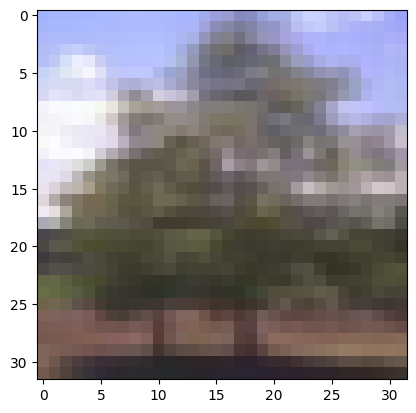

In [ ]:
# plot images
import matplotlib.pyplot as plt
plt.imshow(plotter[0,:,:,:].permute(1,2,0))

In [ ]:
# model = Transformer(device=device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1).to(device)
# loss = nn.BCEWithLogitsLoss(reduction="mean")
# optimizer = torch.optim.Adam(model.parameters(),betas=(.9,.98),eps=1e-9)
# scheduled_optimizer = ScheduledOptimizer(optimizer,d_model=16)


num_epoch = 5
train_loss_list, test_loss_list = list(), list()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("num_param:", total_params)

for i in range(num_epoch):

    ## train
    model.train()

    total_loss = 0
    count = 0


    for batch_idx, (image, label) in enumerate(train_loader):
        if batch_idx % 100 == 0:
          print(f"Batch: {batch_idx}")

        image = image.reshape(-1,3,1024).transpose(1,2)
        x, y = image[:,:512,:].to(device), image[:,512:,:].to(device) # shape = 100, 512, 3

        y_ = torch.zeros([y.shape[0],1,3],requires_grad=False).to(device)
        y_ = torch.cat([y_,y[:,:-1,:]],dim=1)

        logit = model.forward(x,y_) # shape = 100, 512, 3
        cost = loss(logit, y)

        total_loss += cost.item() * y.shape[0] * y.shape[1] * y.shape[2]

        scheduled_optimizer.zero_grad()
        cost.backward()
        scheduled_optimizer.update_parameter_and_learning_rate()

    ave_loss = total_loss/len(train_data)
    train_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("\nEpoch %d Train: %.3f w/ Learning Rate: %.5f"%(i,ave_loss,scheduled_optimizer.lr))

    ## test
    model.eval()

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):

            image = image.reshape(-1,3,1024).transpose(1,2)
            x, y = image[:,:512,:].to(device), image[:,512:,:].to(device)

            # zero first time step to condition first output on prev context
            y_ = torch.zeros([y.shape[0],1,3],requires_grad=False).to(device)
            y_ = torch.cat([y_,y[:,:-1,:]],dim=1)

            logit = model.forward(x,y_)
            cost = loss(logit, y)

            total_loss += cost.item() * y.shape[0] * y.shape[1] * y.shape[2]

    ave_loss = total_loss/len(test_data)
    test_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("Epoch %d Test: %.3f"%(i,ave_loss))


num_param: 14435
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 0 Train: 852.490 w/ Learning Rate: 0.00148
Epoch 0 Test: 850.954
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 1 Train: 852.588 w/ Learning Rate: 0.00198
Epoch 1 Test: 851.252
Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400

Epoch 2 Train: 852.295 w/ Learning Rate: 0.00247
Epoch 2 Test: 851.735
Batch: 0


KeyboardInterrupt: 